<a href="https://colab.research.google.com/github/hcarlens/DQN/blob/master/Simple_DQN_on_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# import the necessary packages
import numpy as np
import gym
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline

In [4]:
# set hyperparameters (mostly taken from DQN paper)
num_episodes = 30
max_num_steps = 200
start_epsilon = 1
end_epsilon = 0.01
epsilon_decay_rate = 0.99
discount_rate = 0.99
batch_size = 32
optimizer_learning_rate = 0.00025
buffer_length = 50000
target_update_steps = 1000

In [31]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
# define Q-network (two layers with 32 neurons each)
# 4 inputs (one for each scalar observable) +1 to represent the action
# todo: try other network architectures
# todo: change to 4 inputs; 5 outputs to require fewer forward passes
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu,
                       input_shape=(5,)),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(learning_rate=optimizer_learning_rate)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [14]:
# define a memory buffer
class MemoryBuffer:
  def __init__(self):
    self.experience_buffer = deque(maxlen=buffer_length)

  def add_memory(self, memory):
    self.experience_buffer.append(memory)
    
  def sample_minibatch(self, batch_size):
    return random.sample(self.experience_buffer, min(len(self.experience_buffer), batch_size))

In [18]:
def parse_minibatch(minibatch, target_network):
    input_cache = []
    label_cache = []
    
    # todo: make this more efficient by turning the sampled mini batch into one tensor
    # parse all the relevant states in our replay buffer
    for state, action, reward, next_state, done in minibatch:
        if done: 
            target_q_value = reward
        else:         
            max_q_next_state = max(target_network.predict(
                np.array([np.append(next_state,0), np.append(next_state,1)])))[0]
            
            target_q_value = reward + discount_rate * max_q_next_state

        input_cache.append(np.append(state, action))
        label_cache.append(np.array(target_q_value))
    return input_cache, label_cache

In [26]:
class Trainer:
    def __init__(self, env, q_network, target_network, memory_buffer, epsilon):
        self.q_network = q_network
        self.target_network = target_network
        self.memory_buffer = memory_buffer
        self.env = env
        self.total_steps = 0
        self.episode_lengths = []
        self.epsilon = epsilon
        print('Trainer initialised')
        
    def run(self, num_episodes):
        # run through episodes
        for e in range(num_episodes):
            observation = self.env.reset()

            for t in range(max_num_steps):
                input = np.array([np.append(observation,0), np.append(observation,1)])
                # todo: review distribution of inputs, and consider normalising

                # set the target network to be the q-network every so often
                if self.total_steps % target_update_steps == 0:
                    self.target_network.set_weights(q_network.get_weights())
                    print(self.total_steps, ' steps taken. Target network weights updated. ')

                # with probability epsilon, choose a random action
                # otherwise use Q-network to pick action 
                if random.uniform(0, 1) < self.epsilon:
                    action = self.env.action_space.sample()
                else:
                    action = np.argmax(self.q_network.predict(input))

                next_observation, reward, done, info = env.step(action)

                # add memory to buffer
                memory = (observation, action, reward, next_observation, done)
                self.memory_buffer.add_memory(memory)

                # sample a minibatch of experiences and update q-network
                minibatch = memory_buffer.sample_minibatch(batch_size)
                minibatch_inputs, minibatch_q_values = parse_minibatch(minibatch, self.target_network)
                self.q_network.fit(np.array(minibatch_inputs), np.array(minibatch_q_values), verbose=0)

                observation = next_observation
                self.total_steps += 1
                if done or t == max_num_steps - 1:
                    break 

            self.episode_lengths.append(t)
            if e % 10 == 0:
                print("Episode {} finished after {} timesteps. 100 ep running avg {}. Epsilon {}. Memory buffer length {}.".format(e, t+1, np.floor(np.average(self.episode_lengths[-100:])), self.epsilon, len(self.memory_buffer.experience_buffer)))

            # decrease epsilon value
            self.epsilon = max(self.epsilon * epsilon_decay_rate, end_epsilon)

In [27]:
# todo: add tensorboard logging
# initialise environment, required objects, and some variables
env = gym.make('CartPole-v0')

q_network = build_model()
target_network = build_model()
memory_buffer = MemoryBuffer()

trainer = Trainer(env=env, q_network=q_network, target_network=target_network, memory_buffer=memory_buffer, epsilon=start_epsilon)
trainer.run(20)

Trainer initialised
0  steps taken. Target network weights updated. 
Episode 0 finished after 37 timesteps. 100 ep running avg 36.0. Epsilon 1. Memory buffer length 37.
Episode 10 finished after 24 timesteps. 100 ep running avg 25.0. Epsilon 0.9043820750088043. Memory buffer length 293.


Text(0.5, 1.0, 'Double DQN; two 16-neuron layers; 0.0025 lr')

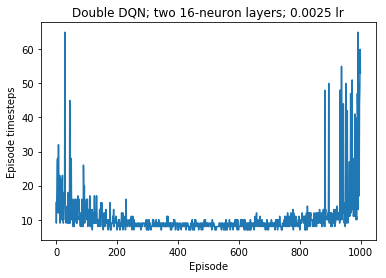

In [17]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(episode_lengths,label='episode length')
ax.set_xlabel('Episode')
ax.set_ylabel('Episode timesteps')
ax.set_title('Double DQN; two 16-neuron layers; 0.0025 lr')